In [27]:
                    # MNIST data (digits from 0 to 9) classification with Fully-connected Deep Neural Networks
# --- Importing the relevant libraries ---
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch  
import torch.nn as nn 
import torch.functional as F
from torch.utils.data import DataLoader # Class - DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [28]:
# --- Retrieving the datasets ---  large database of handwritten digits
mnist_training_set = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
mnist_validation_set = datasets.MNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

In [29]:
# --- Verifying what the retrieved datasets look like ---
print(f'MNIST training_set = {mnist_training_set}')
print(f'\nMNIST validation_set = {mnist_validation_set}')
print(f'\nBoth training and validation MNIST datasets are the same = {mnist_training_set == mnist_validation_set}')

MNIST training_set = Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

MNIST validation_set = Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

Both training and validation MNIST datasets are the same = False


In [30]:
# --- Verifying the dimensions and other useful information about the datasets ---
print(f'Training_set dimensions = {mnist_training_set.data.shape}') # dimension of the training dataset
print(f'Validation_set dimensions = {mnist_validation_set.data.shape}') # dimension of the validation dataset

print(f'\nTraining_set info = {mnist_training_set.data.size}') # method, type and address of the training_set object
print(f'Validation_set info = {mnist_validation_set.data.size}') # method, type and address of the validation_set object

print(f'\nTraining_set matrices = {mnist_training_set.data}') # Showing the data of the training set as tensors (matrices)
print(f'Validation_set matrices = {mnist_validation_set.data}') # Showing the data of the validation set as tensors (matrices)
# plt.imshow(training_set[0])
# plt.show()

Training_set dimensions = torch.Size([60000, 28, 28])
Validation_set dimensions = torch.Size([10000, 28, 28])

Training_set info = <built-in method size of Tensor object at 0x7f34ec0f33d0>
Validation_set info = <built-in method size of Tensor object at 0x7f34ec0f0630>

Training_set matrices = tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0

In [31]:
# --- Assigning the datasets to DataLoader objects in order to use them during the traing ---
    # It allows to retrieve the data portions by assigning the batch size parameter

# Initializing the train_loader and validation_loader objects, giving the datasets as parameter values
train_loader = DataLoader(dataset = mnist_training_set, batch_size = 25) 
validation_loader = DataLoader(dataset = mnist_validation_set, batch_size = 10)

In [32]:
# --- Creating a Module or a Class of the Model --- # Dropout regularization term can be omitted while using batch normalization and vice versa
class DNN_MNIST(nn.Module):
    # Constructor
    def __init__(self, Layers, drop_probability = 0):
        super(DNN_MNIST, self).__init__()
        self.bn = []
        self.drop = nn.Dropout(p = drop_probability)
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity = 'relu')
            self.hidden.append(linear)
            self.bn.append(nn.BatchNorm1d(output_size))
            
    # Prediction
    def forward(self, x):
        n_layers = len(self.hidden)
        for (layer_index, linear_layer) in zip(range(n_layers), self.hidden):
            if layer_index < n_layers - 1:
                x = torch.relu(self.drop(self.bn[layer_index](linear_layer(x))))
            else:
                x = linear_layer(x)
            
        return x

    
first_input_size = mnist_training_set.data[0].shape[0] * mnist_training_set.data[0].shape[1]
print(f"The size of the input : {first_input_size}")

model = DNN_MNIST([first_input_size, 200, 500, 500, 400, 300, 50, 10], drop_probability = 0.2) # [first_input_size, 200, 500, 500, 400, 300, 50, 10] 

The size of the input : 784


In [33]:
# --- Defining a function to train the model ---
torch.manual_seed(1)

def train(model, train_loader, validation_loader, criterion, optimizer, epochs):
    loss_accuracy = {'training_loss' : [], 'validation_accuracy' : []}
    Softmax = nn.Softmax(dim = -1)
    for epoch in range(epochs):
        # Training each epoch
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x.view(-1, first_input_size))
            loss = criterion(yhat, y)
            loss_accuracy['training_loss'].append(loss.data.item())
            loss.backward()
            optimizer.step()
            
                         
        # Validating the accuracy
        model.eval()
        correct = 0
        for x, y in validation_loader:
            yhat = model(x.view(-1, first_input_size))
            _, label = torch.max(Softmax(yhat), 1)
            correct += (label == y).sum().item()
        accuracy = 100 * (correct / len(mnist_validation_set))
        loss_accuracy['validation_accuracy'].append(accuracy) 
     
    return loss_accuracy

In [34]:
# --- Defining the Criterion, optimiser and epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
epochs = 20

In [35]:
# Start training the model
training_results = train(model, train_loader, validation_loader, criterion, optimizer, epochs)

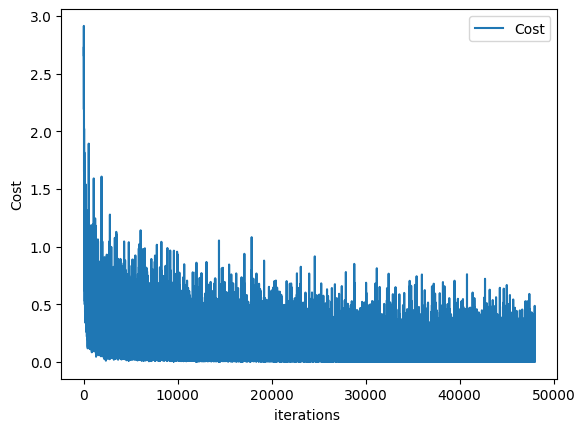

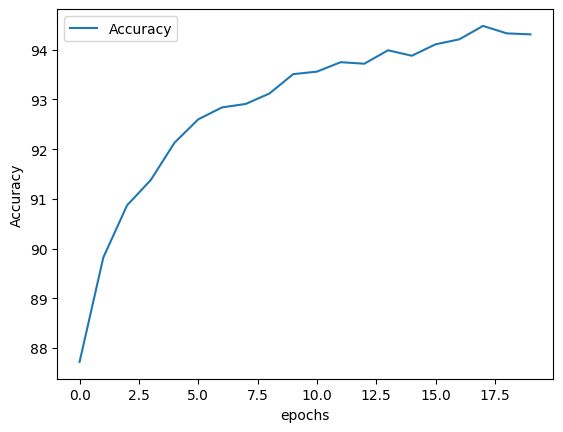

In [36]:
# --- Plotting the training loss and validation accuracy ---
x_axis = range(len(training_results['training_loss']))
plt.plot(x_axis, training_results['training_loss'], label='Cost')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

x_axis = range(len(training_results['validation_accuracy']))
plt.plot(x_axis, training_results['validation_accuracy'], label='Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')   
plt.legend()
plt.show()
